https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=10987&end_date=2025-04-02&f=json


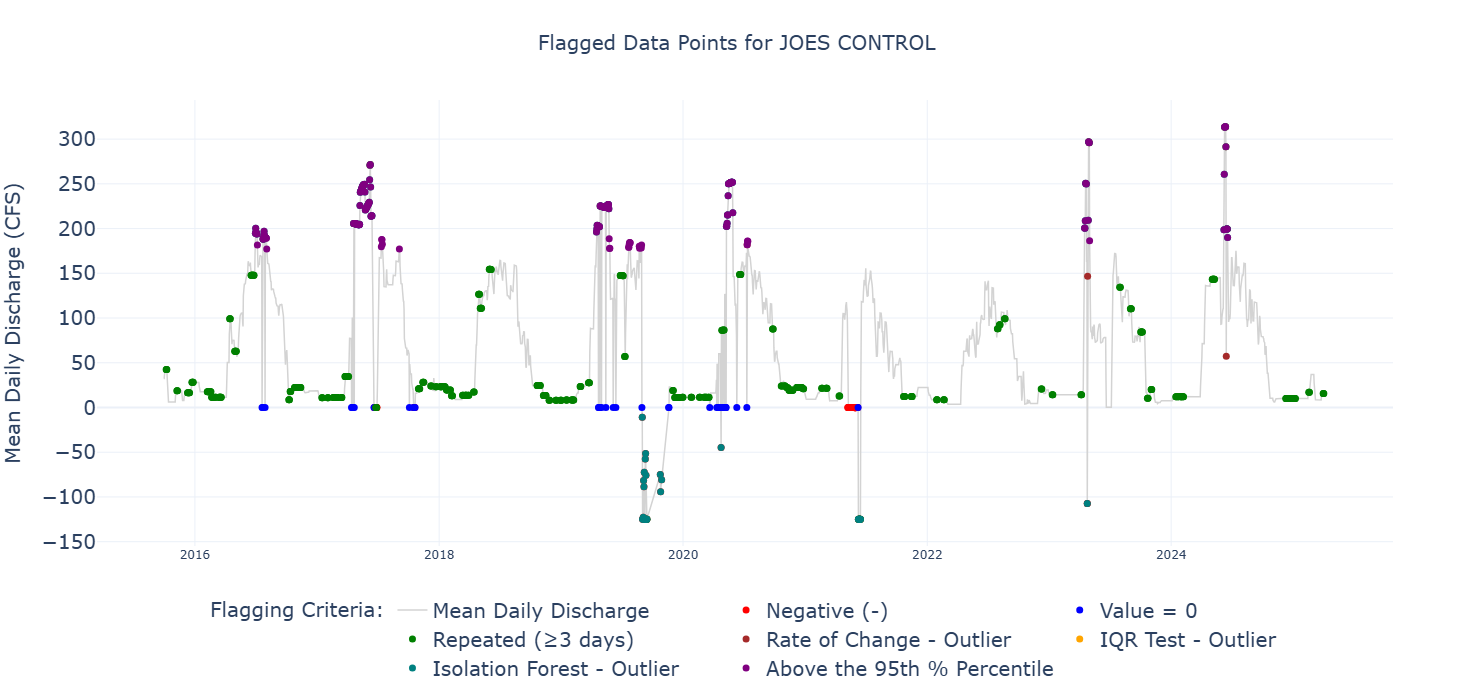

https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=3133&end_date=2025-04-02&f=json


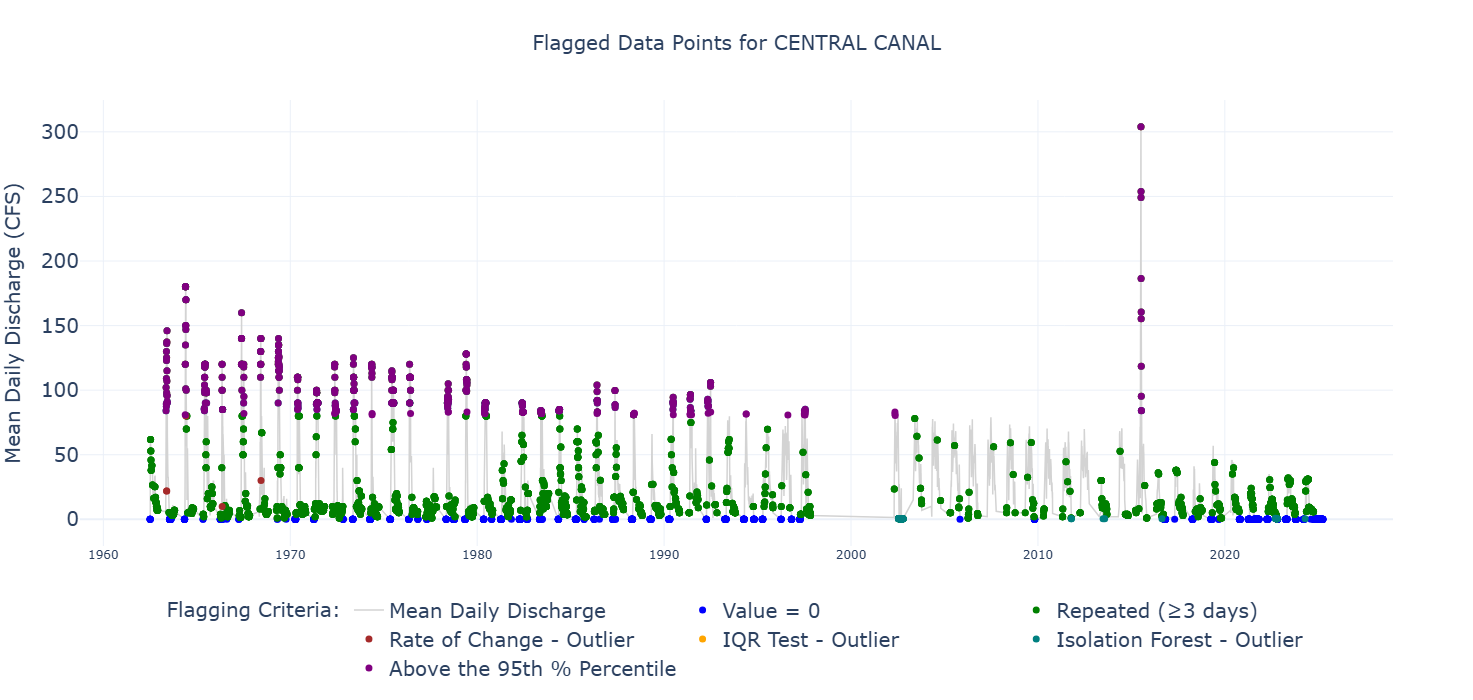

https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=10543&end_date=2025-04-02&f=json


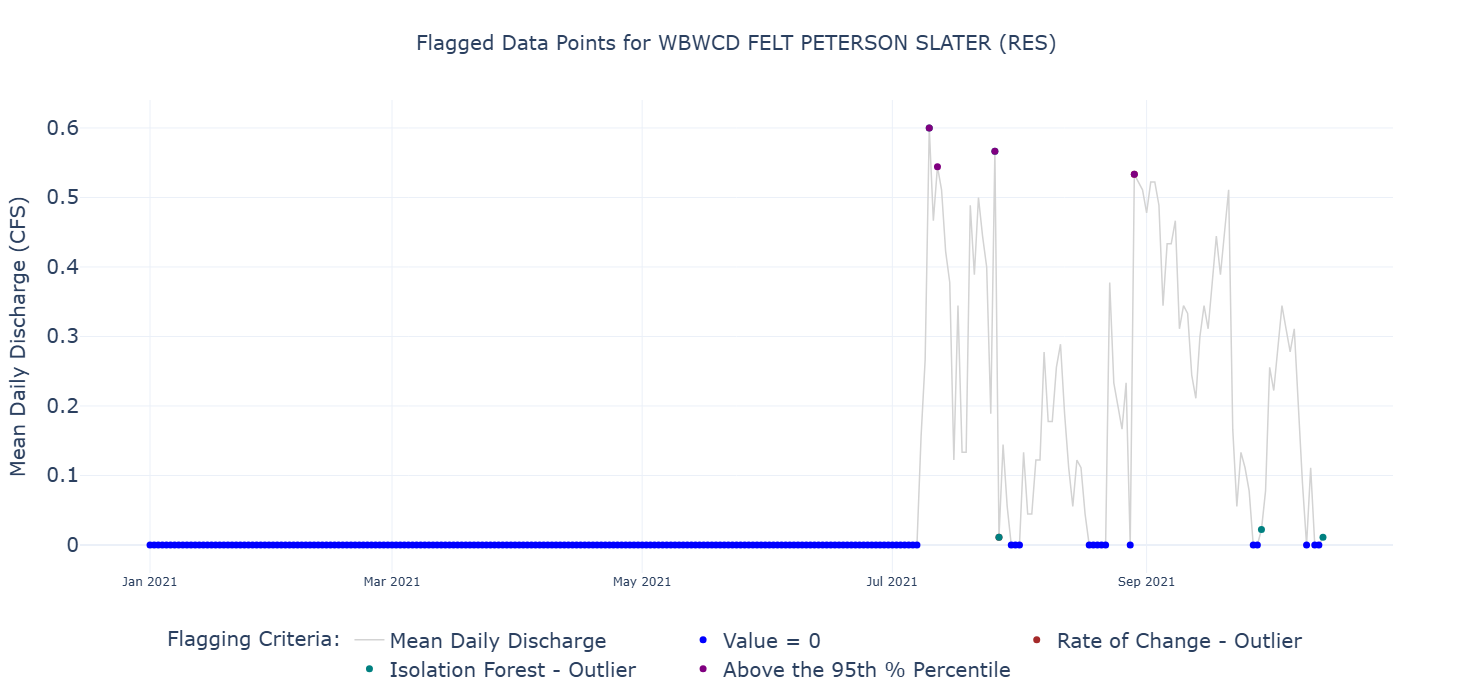

In [13]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go

# Define the UTDWR site IDs
site_ids = ["10987", "3133", "10543"]  # Add more site IDs as needed

# Loop through each site_id
for DivrtID in site_ids:
    # Define parameters
    end_date = datetime.today().strftime("%Y-%m-%d")  # Get today's date in YYYY-MM-DD format

    # Construct API URL
    api_url = f"https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id={DivrtID}&end_date={end_date}&f=json"
    print(api_url)

    # Fetch data from the API
    response = requests.get(api_url)

    # Check if request was successful
    if response.status_code == 200:
        data = response.json()

        # Extract time series data
        if "data" in data:
            df = pd.DataFrame(data["data"], columns=["date", "value"])
            df.rename(columns={"date": "Date", "value": "DISCHARGE"}, inplace=True)  # Ensure correct column names

            # Add metadata as new columns
            metadata_fields = ["station_id", "station_name", "system_name", "units"]
            metadata = {field: data.get(field, "N/A") for field in metadata_fields}

            # Add missing metadata columns with default values ("N/A")
            for key, value in metadata.items():
                df[key] = value

            # Reorder columns only with existing ones
            column_order = ["Date", "DISCHARGE"]  # Start with core columns
            for field in metadata_fields:
                if field in df.columns:
                    column_order.append(field)
            df = df[column_order]

        else:
            print("Error: 'data' key not found in API response.")
            continue
    else:
        print(f"Error fetching data: {response.status_code}")
        continue

    # Convert 'DISCHARGE' to numeric, coercing errors to NaN
    df['DISCHARGE'] = pd.to_numeric(df['DISCHARGE'], errors='coerce')

    # === FLAGGING CRITERIA === #
    # Exclude 0 values when flagging for negative values
    df['FLAG_NEGATIVE'] = (df['DISCHARGE'] < 0) & (df['DISCHARGE'] != 0)

    # Exclude 0 values for "FLAG_ZERO" criteria
    df['FLAG_ZERO'] = (df['DISCHARGE'] == 0)

    # 95th Percentile of DISCHARGE values, excluding 0 values
    discharge_95th_percentile = np.percentile(df[df['DISCHARGE'] != 0]['DISCHARGE'].dropna(), 95)
    df['FLAG_Discharge'] = (df['DISCHARGE'] > discharge_95th_percentile) & (df['DISCHARGE'] != 0)

    # IQR Outlier Detection, excluding 0 values
    Q1, Q3 = df[df['DISCHARGE'] != 0]['DISCHARGE'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df['FLAG_IQR'] = ((df['DISCHARGE'] < lower_bound) | (df['DISCHARGE'] > upper_bound)) & (df['DISCHARGE'] != 0)

    # Calculate absolute rate of change between consecutive days, excluding 0 values
    df['RATE_OF_CHANGE'] = df['DISCHARGE'].diff().abs()
    df['FLAG_RoC'] = (df['RATE_OF_CHANGE'] > discharge_95th_percentile) & (df['DISCHARGE'] != 0)

    # Flag repeated values (≥3 consecutive days), excluding 0 values
    df['FLAG_REPEATED'] = (
        df['DISCHARGE']
        .where(df['DISCHARGE'] != 0)
        .groupby((df['DISCHARGE'] != df['DISCHARGE'].shift()).cumsum())
        .transform('count') >= 3
    )

    # Isolation Forest Outlier Detection, excluding 0 values
    df_clean = df[df['DISCHARGE'] != 0].dropna(subset=['DISCHARGE'])
    model = IsolationForest(contamination=0.05, random_state=42)
    df_clean['OUTLIER_IF'] = model.fit_predict(df_clean[['DISCHARGE']])
    df['OUTLIER_IF'] = False
    df.loc[df_clean.index, 'OUTLIER_IF'] = df_clean['OUTLIER_IF'] == -1

    # Combine all flag conditions into a single FLAGGED column
    df['FLAGGED'] = df[
        ['FLAG_NEGATIVE', 'FLAG_ZERO', 'FLAG_REPEATED', 'FLAG_IQR', 'OUTLIER_IF', 'FLAG_Discharge', 'FLAG_RoC']
    ].any(axis=1)

    # Define plot title
    plot_title = f"Flagged Data Points for {metadata.get('station_name', 'Station ' + DivrtID)}"

    # Define custom legend names and colors
    flag_colors = {
        'FLAG_NEGATIVE': ('red', 'Negative (-)'),
        'FLAG_ZERO': ('blue', 'Value = 0'),
        'FLAG_REPEATED': ('green', 'Repeated (≥3 days)'),
        'FLAG_RoC': ('brown', 'Rate of Change - Outlier'),
        'FLAG_IQR': ('orange', 'IQR Test - Outlier'),
        'OUTLIER_IF': ('teal', 'Isolation Forest - Outlier'),
        'FLAG_Discharge': ('purple', 'Above the 95th % Percentile')
    }

    # Create plot
    fig = go.Figure()

    # Background Line (Mean Daily Discharge)
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['DISCHARGE'],
        mode='lines',
        line=dict(color='lightgray', width=1.5),
        name='Mean Daily Discharge',
        connectgaps=False
    ))

    # Add flagged points
    for flag, (color, legend_name) in flag_colors.items():
        subset = df[df[flag]]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset['Date'], y=subset['DISCHARGE'],
                mode='markers',
                marker=dict(color=color, size=7),
                name=legend_name
            ))

    # Update layout with title and legend placement
    fig.update_layout(
        title=dict(
            text=plot_title,
            x=0.5,  # Centers the title
            font=dict(size=20)
        ),
        yaxis=dict(
            title="Mean Daily Discharge (CFS)",
            title_font=dict(size=20),
            tickfont=dict(size=20)
        ),
        legend=dict(
            orientation="h",  # Horizontal legend
            yanchor="top",
            y=-0.1,  # Moves the legend below the plot
            xanchor="center",
            x=0.5,
            title=dict(text="Flagging Criteria:", font=dict(size=20)),
            font=dict(size=20)
        ),
        template="plotly_white",
        width=1400,
        height=700
    )
        # Show the plot
    fig.show()